# Resources
Based on https://www.kaggle.com/code/vitouphy/phoneme-recognition-with-wav2vec2 with alterations for my own understanding of the steps.

Additional resources:
* https://huggingface.co/blog/fine-tune-xlsr-wav2vec2

In [1]:
!pip install datasets>=1.18.3
!pip install transformers==4.17.0
!pip install librosa
!pip install seaborn
!pip install jiwer
!pip install phonecodes
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 32.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.0
    Uninstalling transformers-4.47.0:
      Successfully uninstalled transformers-4.47.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.16.11 requires transformers>=4.33.1, but you have transformers 4.17.0 which is incompatible.
sentence-transformers 3.3.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.3/107.3 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 59.0 MB/s eta 0:00:00
  Attempting u

# Dataset handling

## load dataset

In [2]:
from datasets import load_dataset, Audio, Dataset
from tqdm.auto import tqdm

import os
import numpy as np
import pandas as pd
import torchaudio
import evaluate
from phonecodes import phonecodes


# disables weight and bias tracking. I think deprecated?
#os.environ["WANDB_DISABLED"] = "true"

In [3]:
#add input source from right menu first
audio_folder = "/kaggle/input/ulster-irish-audio/wav_files/"
data_path = "/kaggle/input/ulster-wav-phon/irish_data_cleaned.csv"

In [4]:
data_df = pd.read_csv(data_path)

file was decapitalized for some reason when uploading to kaggle

In [5]:
data_df.replace(to_replace="R.wav",value="r.wav",inplace=True)

complete file path for easier processing

In [6]:
data_df["file"] = data_df["file"].map(lambda x: audio_folder + x)

In [7]:
data_df.head()

,file,phonemes
0,/kaggle/input/ulster-irish-audio/wav_files/lit...,lʲ i tʲ ia mˠ
1,/kaggle/input/ulster-irish-audio/wav_files/cod...,ˈ k o d̪ˠ ə lʲ
2,/kaggle/input/ulster-irish-audio/wav_files/cae...,k eː ʃ ia mˠ
3,/kaggle/input/ulster-irish-audio/wav_files/asp...,ˈ a sˠ pˠ ə l̻ˠ o dʲ
4,/kaggle/input/ulster-irish-audio/wav_files/cei...,c e fʲ i lʲ ə pˠ o d̪ˠ


## Split Dataset

### Resplit
resplit combined set back into random train/val/test split

In [8]:
data_list = data_df.to_dict(orient="records")
data = {idx: row for (idx, row) in enumerate(data_list)}

In [9]:
import random

keys = [key for key in data.keys() if len(data[key]) == 2]
random.Random(101).shuffle(keys)

num_train = int(len(keys) * 0.8)
num_valid = int(len(keys) * 0.1)
num_test = len(keys) - num_train - num_valid

train_keys = keys[:num_train]
valid_keys = keys[num_train:num_train + num_valid]
test_keys = keys[-num_test:]

In [10]:
train = { key:data[key] for key in train_keys}#[:int(len(train_keys)*.561)] }
valid = { key:data[key] for key in valid_keys}#[:int(len(valid_keys)*.561)] }
test  = { key:data[key] for key in test_keys}#[:int(len(test_keys)*.561)] }

How much data is in each set?

In [11]:
import librosa

def get_durations(dict_data):
    total_durations = 0

    for entry in dict_data.values():
        audio_data, _ = librosa.load(entry['file'], sr=16_000)
        duration = len(audio_data) / 16_000
        total_durations += duration

    return int(total_durations)

In [12]:
print(f"Duration of Train: {get_durations(train) // 60} mns")
print(f"Duration of Valid: {get_durations(valid) // 60} mns")
print(f"Duration of Test : {get_durations(test) // 60} mns")

Duration of Train: 244 mns
Duration of Valid: 30 mns
Duration of Test : 30 mns


## Preprocessing
convert to HuggingFace Dataset Format

In [13]:
def convert_to_feature_dict(data_dict):
    # convert each feature into an array instead
    audio_files = []
    phonetic = []
    for key, value in data_dict.items():
        audio_files.append(value['file'])
        phonetic.append(value['phonemes'])
    
    return {
        'audio_file': audio_files,
        'phonetic': phonetic
    }

In [14]:
train = convert_to_feature_dict(train)
valid = convert_to_feature_dict(valid)
test  = convert_to_feature_dict(test)

In [15]:
train_dataset = Dataset.from_dict(train)
valid_dataset = Dataset.from_dict(valid)
test_dataset = Dataset.from_dict(test)

In [16]:
print(train_dataset)

Dataset({
    features: ['audio_file', 'phonetic'],
    num_rows: 15308
})


We will strip primary and secondary stress markers to focus only on segmental feature prediction.

In [17]:
primary_stress = "ˈ"
secondary_stress = "ˌ"
suprasegmentals = {primary_stress, secondary_stress}
condition = lambda x: x in suprasegmentals  
def strip_suprasegmentals(example):
    phon_string = example['phonetic']
    phone_list = phon_string.split()
    stripped_list = list(filter(lambda x: not condition(x), phone_list))
    stripped_string = " ".join(stripped_list)
    example['phonetic'] = stripped_string
    return example

In [18]:
train_dataset = train_dataset.map(strip_suprasegmentals)
valid_dataset = valid_dataset.map(strip_suprasegmentals)
test_dataset = test_dataset.map(strip_suprasegmentals)

Map:   0%|          | 0/15308 [00:00<?, ? examples/s]

Map:   0%|          | 0/1913 [00:00<?, ? examples/s]

Map:   0%|          | 0/1915 [00:00<?, ? examples/s]

In [19]:
train_dataset[0]

{'audio_file': '/kaggle/input/ulster-irish-audio/wav_files/carbad.wav',
 'phonetic': 'k a ɾˠ ə bˠ ə d̪ˠ'}

In [20]:
train_phonetics = [phone for x in train_dataset for phone in x['phonetic'].split()]
valid_phonetics = [phone for x in valid_dataset for phone in x['phonetic'].split()]
test_phonetics = [phone for x in test_dataset for phone in x['phonetic'].split()]

print("num of train phones:\t", len(set(train_phonetics)))
print("num of valid phones:\t", len(set(valid_phonetics)))
print("num of test phones:\t", len(set(test_phonetics)))

num of train phones:	 80
num of valid phones:	 60
num of test phones:	 65


## Visualize phonetic Distribution

In [21]:
set(train_phonetics)-set(valid_phonetics)

{'d',
 'l',
 'l̥ʲ',
 'm',
 'n',
 'nˠ',
 'n̻̊ˠ',
 'p',
 's',
 't̪',
 'w',
 'zˠ',
 'æ',
 'ɒ',
 'ɛ',
 'ɪ',
 'ɲ̊',
 'ɹ',
 'ʌ',
 'ʤ'}

In [22]:
phone_vocabs = set(train_phonetics)
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    # eliminate h# for visualization purposes
    return [phone_counts[phone] for phone in phone_vocabs]

In [23]:
train_phone_counts = count_frequency(train_phonetics)
valid_phone_counts = count_frequency(valid_phonetics)
test_phone_counts  = count_frequency(test_phonetics)

In [24]:
train_phone_ratio = [count / sum(train_phone_counts) for count in train_phone_counts]
valid_phone_ratio = [count / sum(valid_phone_counts) for count in valid_phone_counts]
test_phone_ratio  = [count / sum(test_phone_counts) for count in test_phone_counts]

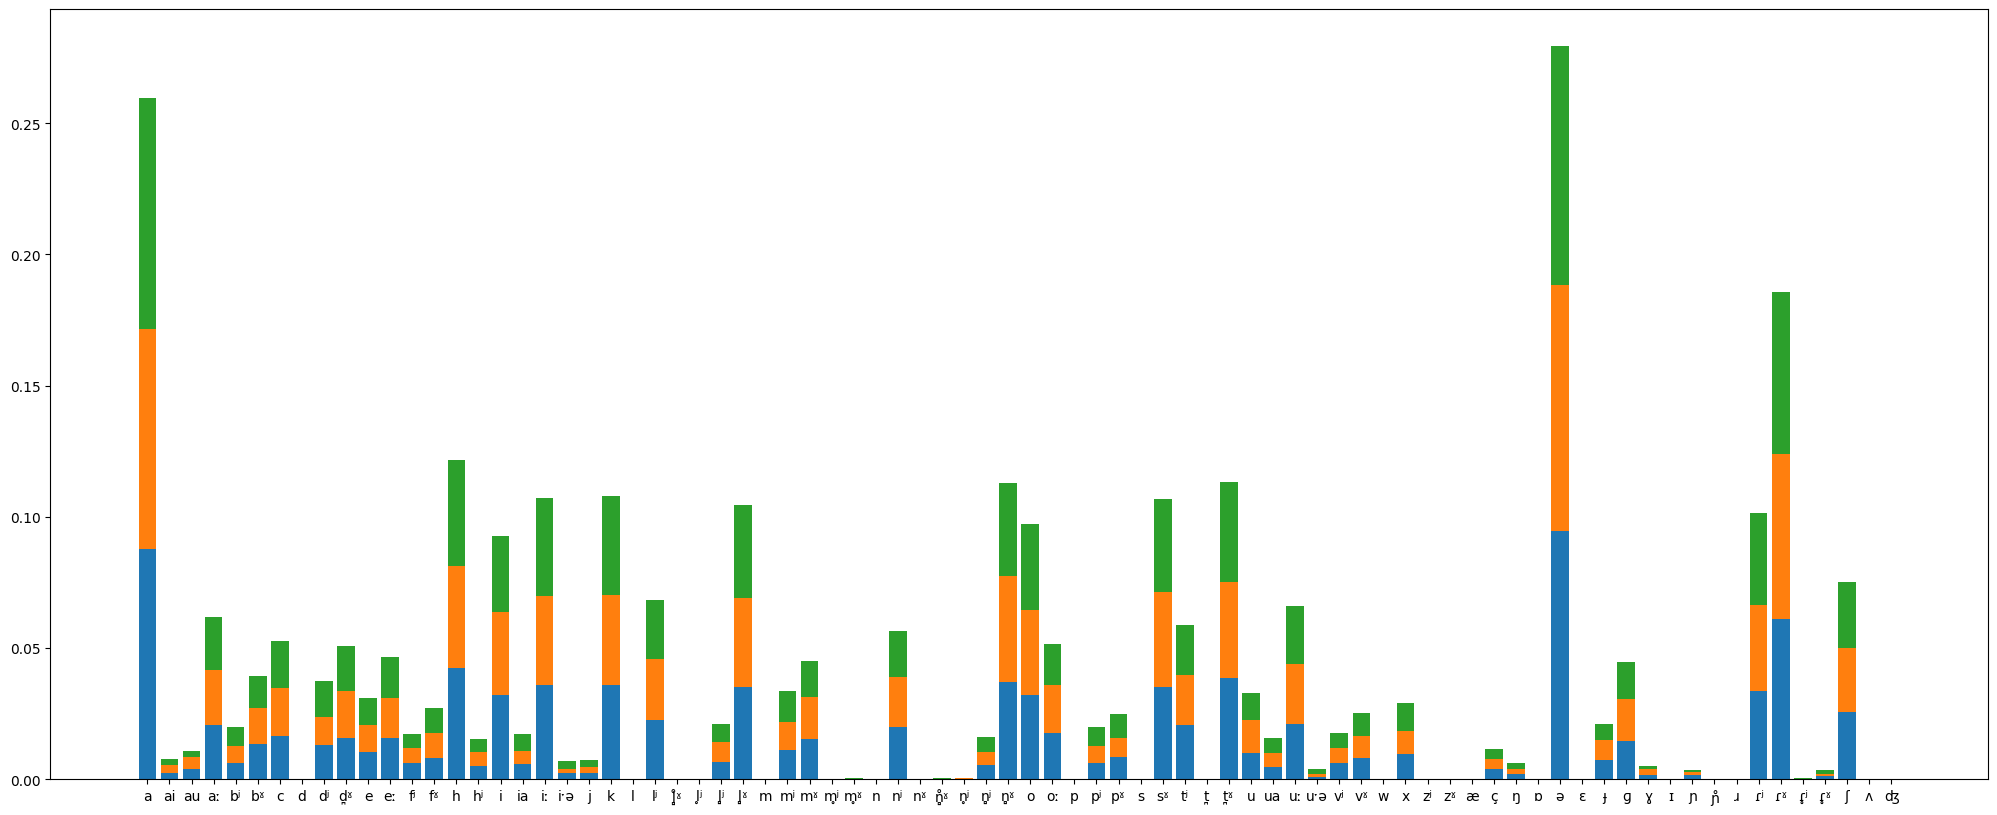

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

plt.bar(phone_vocabs, train_phone_ratio)
plt.bar(phone_vocabs, valid_phone_ratio, bottom=train_phone_ratio)
plt.bar(phone_vocabs, test_phone_ratio, bottom=[(x+y) for x,y in zip(train_phone_ratio, valid_phone_ratio)])

plt.show()

## Load Audio

In [26]:
train_dataset = (train_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
valid_dataset = (valid_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))
test_dataset = (test_dataset
                 .cast_column("audio_file", Audio(sampling_rate=16_000))
                 .rename_column('audio_file', 'audio'))

In [27]:
train_dataset[0]

{'audio': {'path': '/kaggle/input/ulster-irish-audio/wav_files/carbad.wav',
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 16000},
 'phonetic': 'k a ɾˠ ə bˠ ə d̪ˠ'}

In [28]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(train_dataset)-1)

print("Phonetics:", train_dataset[rand_int]["phonetic"])
print("Input array shape:", train_dataset[rand_int]["audio"]["array"].shape)
print("Sampling rate:", train_dataset[rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=train_dataset[rand_int]["audio"]["array"], autoplay=False, rate=16000)

Phonetics: k iː nʲ vʲ eː sˠ ə
Input array shape: (23808,)
Sampling rate: 16000


## save datasets 

In [29]:
# Saves to 'kaggle/working/'
from datasets import DatasetDict
dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset,
    "test": test_dataset
})

dataset.save_to_disk("teangl_phon_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/15308 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1913 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1915 [00:00<?, ? examples/s]

# Build IPA charset vocab

In [30]:
vocab_train = list(set(train_phonetics)) + [' ']
vocab_valid = list(set(valid_phonetics)) + [' ']
vocab_test  = list(set(test_phonetics)) + [' ']

In [31]:
vocab_list = list(set(vocab_train + vocab_valid + vocab_test))
vocab_dict = {v: k for k, v in enumerate(sorted(vocab_list))}

print(vocab_dict)

{' ': 0, 'a': 1, 'ai': 2, 'au': 3, 'aː': 4, 'bʲ': 5, 'bˠ': 6, 'c': 7, 'd': 8, 'dʲ': 9, 'd̪ˠ': 10, 'e': 11, 'eː': 12, 'f': 13, 'fʲ': 14, 'fˠ': 15, 'h': 16, 'hʲ': 17, 'i': 18, 'ia': 19, 'iː': 20, 'iˑə': 21, 'j': 22, 'k': 23, 'l': 24, 'lʲ': 25, 'l̻̊ˠ': 26, 'l̥ʲ': 27, 'l̻ʲ': 28, 'l̻ˠ': 29, 'm': 30, 'mʲ': 31, 'mˠ': 32, 'm̥ʲ': 33, 'm̥ˠ': 34, 'n': 35, 'nʲ': 36, 'nˠ': 37, 'n̻̊ˠ': 38, 'n̥ʲ': 39, 'n̻ʲ': 40, 'n̻ˠ': 41, 'o': 42, 'oː': 43, 'p': 44, 'pʲ': 45, 'pˠ': 46, 's': 47, 'sˠ': 48, 'tʲ': 49, 't̪': 50, 't̪ˠ': 51, 'u': 52, 'ua': 53, 'uː': 54, 'uˑə': 55, 'vʲ': 56, 'vˠ': 57, 'w': 58, 'x': 59, 'zʲ': 60, 'zˠ': 61, 'æ': 62, 'ç': 63, 'ŋ': 64, 'ɒ': 65, 'ə': 66, 'ɛ': 67, 'ɟ': 68, 'ɡ': 69, 'ɣ': 70, 'ɪ': 71, 'ɲ': 72, 'ɲ̊': 73, 'ɹ': 74, 'ɾʲ': 75, 'ɾˠ': 76, 'ɾ̥ʲ': 77, 'ɾ̥ˠ': 78, 'ʃ': 79, 'ʌ': 80, 'ʤ': 81}


In [32]:
# make the space more intuitive to understand
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

84

In [33]:
# save vocab.json
import json
with open('/kaggle/working/vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)